[View in Colaboratory](https://colab.research.google.com/github/rafaelszp/dlnd_face_generation/blob/master/dlnd_face_generation.ipynb)

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
#!git clone https://github.com/rafaelszp/dlnd_face_generation.git
#!cp dlnd_face_generation/*.py .
#!pip install -U matplotlib==2.0.2
#!pip install tqdm

  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 14.6MB 3.3MB/s 
Requirement not upgraded as not directly required: python-dateutil in /usr/local/lib/python3.6/dist-packages (from matplotlib==2.0.2) (2.5.3)
Requirement not upgraded as not directly required: cycler>=0.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib==2.0.2) (0.10.0)
Requirement not upgraded as not directly required: six>=1.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib==2.0.2) (1.11.0)
Requirement not upgraded as not directly required: pytz in /usr/local/lib/python3.6/dist-packages (from matplotlib==2.0.2) (2018.4)
Requirement not upgraded as not directly required: pyparsing!=2.0.0,!=2.0.4,!=2.1.2,!=2.1.6,>=1.5.6 in /usr/local/lib/python3.6/dist-packages (from matplotlib==2.0.2) (2.2.0)
Requirement not upgraded as not directly required: numpy>=1.7.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib==2.0.2) (1.14.3)
  Found existing insta

In [25]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

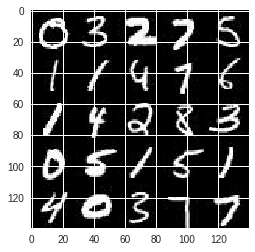

In [26]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

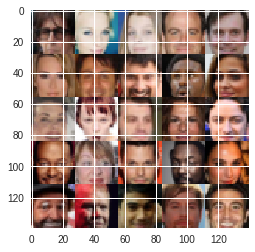

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [44]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    x = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels),name='input_real')
    z = tf.placeholder(tf.float32, shape=(None, z_dim),name='noise')
    l = tf.placeholder(tf.float32,name='learning_rate')

    return x, z, l



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [30]:

leakyRelu = lambda x,alpha=0.2: tf.maximum(x*alpha,x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    def conv(images, n_filters, kernel_size=5, strides=2, kernel_initializer=kernel_init, padding='same',is_first=False):
      x = tf.layers.conv2d(images, n_filters, kernel_size, strides, kernel_initializer=kernel_initializer, padding=padding)
      x = leakyRelu(x)
      if(is_first):
        x = tf.layers.batch_normalization(x, training=True)
      return x
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = conv(images,64,is_first=True)
        # 14x14x64        
        x = conv(x,128)
        # 7x7x128
        x = conv(x,256)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    def deconv(inputs, n_filters, kernel_size=5, strides=2, kernel_initializer=kernel_init, padding='same',is_last=False):
      x = tf.layers.conv2d_transpose(inputs, n_filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding)
      if(not is_last):
        x = leakyRelu(x)
        x = tf.layers.batch_normalization(x, training=is_train)

      return x
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = leakyRelu(x)        
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        x = deconv(x,128)
        # 14x14x128
        x = deconv(x,64)
        # 28x28x64
        
        logits = deconv(x,n_filters=out_channel_dim,kernel_size=3,strides=1,is_last=True)
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gmodel = generator(input_z,out_channel_dim,is_train=True)
    dmodel, dmodel_logits = discriminator(input_real,reuse=False) 
    gxdmodel, gxdmodel_logits = discriminator(gmodel,reuse=True)
    
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dmodel_logits,labels=tf.ones_like(dmodel)*0.9))
    gxdloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.zeros_like(gxdmodel)))
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.ones_like(gxdmodel)))
    
    dloss = dloss + gxdloss
    
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [g for g in t_vars if g.name.startswith('generator')]
    d_vars = [d for d in t_vars if d.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss,var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [51]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    images, noisez, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    dloss,gloss = model_loss(images,noisez,data_shape[3])
    d_train_opt,g_train_opt = model_opt(dloss,gloss,learning_rate,beta1)
    iterations = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #Doing the blablablablablalbla ff
                iterations +=1
                batch_noisez = np.random.uniform(-1,1,size=(batch_size,z_dim))
                dict_d = {
                  images: batch_images,
                  noisez: batch_noisez
                }
                dict_g = {
                    noisez: batch_noisez,
                    images: batch_images,
                }
                _ = sess.run(d_train_opt,feed_dict=dict_d)
                _ = sess.run(g_train_opt,feed_dict=dict_g)
                #calculating loss for the blablablablablalbla
                if(iterations % 10==0):
                  train_loss_d = dloss.eval({images:batch_images,noisez:batch_noisez})
                  train_loss_g = gloss.eval({noisez: batch_noisez})
                  print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                  
                if iterations % 100 == 0:
                    show_generator_output(sess, 25, noisez, data_shape[3], data_image_mode)
                
      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 2.1231
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 3.0206
Epoch 1/2... Discriminator Loss: 0.3730... Generator Loss: 3.2504
Epoch 1/2... Discriminator Loss: 0.3604... Generator Loss: 3.5984
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 3.8156
Epoch 1/2... Discriminator Loss: 0.3613... Generator Loss: 3.5446
Epoch 1/2... Discriminator Loss: 0.3639... Generator Loss: 3.5524
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 3.1198
Epoch 1/2... Discriminator Loss: 0.4862... Generator Loss: 2.2793


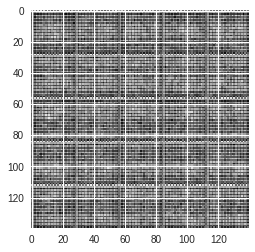

Epoch 1/2... Discriminator Loss: 0.4108... Generator Loss: 2.6240
Epoch 1/2... Discriminator Loss: 0.4238... Generator Loss: 2.6434
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 2.5463
Epoch 1/2... Discriminator Loss: 0.4589... Generator Loss: 2.4309
Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 1.9255
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 2.3664
Epoch 1/2... Discriminator Loss: 0.4820... Generator Loss: 2.6359
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 1.6040
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.3326
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 0.6524


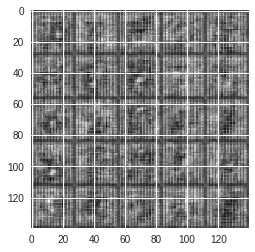

Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 0.9990
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 1.6985
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 0.9373
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.2519
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 1.5752
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 1.4934
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.0517
Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.2144


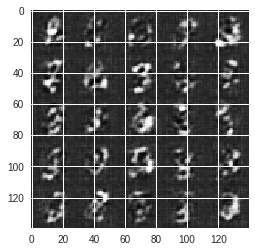

Epoch 1/2... Discriminator Loss: 0.8115... Generator Loss: 1.6473
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 2.0201
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 1.6372
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.7394
Epoch 1/2... Discriminator Loss: 0.6827... Generator Loss: 1.8549
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 3.4320
Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 2.0233
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 2.1922
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 3.5593


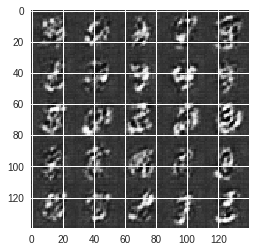

Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 1.7305
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.8095
Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 1.1677
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.9558
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.3543
Epoch 1/2... Discriminator Loss: 0.8722... Generator Loss: 2.4078
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 2.6235
Epoch 1/2... Discriminator Loss: 0.7067... Generator Loss: 1.5623
Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.3133
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 1.9737


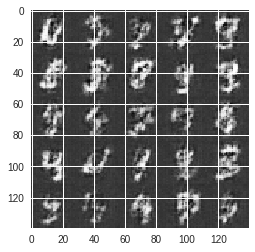

Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.6154
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.5880
Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 1.5483
Epoch 1/2... Discriminator Loss: 0.6648... Generator Loss: 2.5064
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.7902
Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 3.2109
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 2.1172
Epoch 1/2... Discriminator Loss: 0.7645... Generator Loss: 1.3527
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 2.1426
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.9999


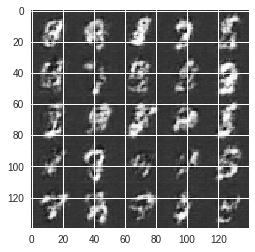

Epoch 1/2... Discriminator Loss: 0.6637... Generator Loss: 1.6252
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 1.9630
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 3.0800
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 1.6938
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 2.4544
Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 2.1253
Epoch 2/2... Discriminator Loss: 0.9008... Generator Loss: 1.0212
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 2.4379
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 2.1639
Epoch 2/2... Discriminator Loss: 0.5763... Generator Loss: 2.3207


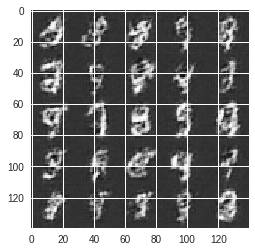

Epoch 2/2... Discriminator Loss: 0.5566... Generator Loss: 2.0631
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 4.1807
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 2.5227
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.4320
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 3.8961
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.9337
Epoch 2/2... Discriminator Loss: 0.5337... Generator Loss: 2.6192
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 3.1442
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.9542


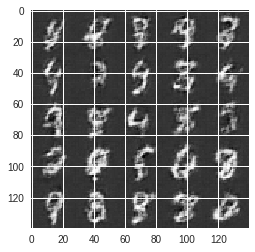

Epoch 2/2... Discriminator Loss: 0.6571... Generator Loss: 1.7281
Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 2.4196
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 1.6608
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 2.8857
Epoch 2/2... Discriminator Loss: 0.6754... Generator Loss: 2.0714
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 2.4129
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 2.0344
Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.8148
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.9118
Epoch 2/2... Discriminator Loss: 0.6368... Generator Loss: 1.9151


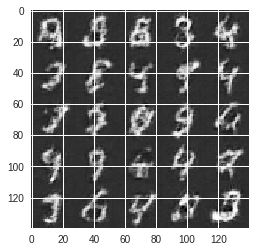

Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 1.5085
Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.9360
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 3.0408
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 2.1605
Epoch 2/2... Discriminator Loss: 0.6462... Generator Loss: 1.6764
Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 1.8225
Epoch 2/2... Discriminator Loss: 0.5822... Generator Loss: 2.3293
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.3302
Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 2.1100


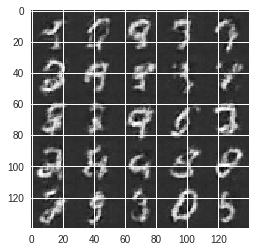

Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.4926
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 2.3839
Epoch 2/2... Discriminator Loss: 0.6612... Generator Loss: 2.2324
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 2.9674
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.3295
Epoch 2/2... Discriminator Loss: 0.6521... Generator Loss: 2.2063
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 1.9796
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 2.2780
Epoch 2/2... Discriminator Loss: 0.5701... Generator Loss: 2.6208
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 3.5176


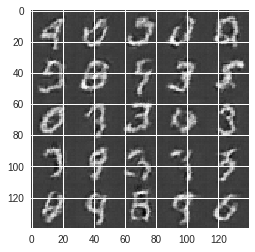

Epoch 2/2... Discriminator Loss: 0.6563... Generator Loss: 2.0728
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 2.5082
Epoch 2/2... Discriminator Loss: 0.6759... Generator Loss: 2.3502
Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 2.0833
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 2.1866
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 2.0616
Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 1.4845


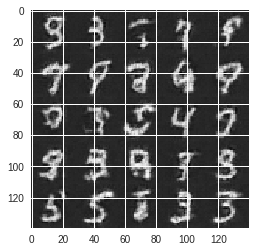

Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 1.4337
Epoch 2/2... Discriminator Loss: 0.6534... Generator Loss: 1.8068
Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 2.1773
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.4639


In [56]:
batch_size = 96
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [0]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.